In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/Colab_Notebooks/Data_Mining_Project/'

Mounted at /content/drive


# Label Encoding & Correlation Matrix

In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/Colab_Notebooks/Data_Mining_Project/'
filename = ["Red_Season.csv" , "White_Season.csv", "Rose_Season.csv", "Sparkling_Season.csv"]
file_names = []

for name in filename:
  file_names.append([name, pd.read_csv(file_path + name)])


for i, [name, df] in enumerate(file_names):
  print('★',name)

  # 相關係數

  import statsmodels.formula.api as smf
  from sklearn.preprocessing import LabelEncoder

  label_encoder = LabelEncoder()
  for col in ['Country', 'Region', 'Winery']:
      df[col] = label_encoder.fit_transform(df[col])

  columns_of_interest = [
      'Name', 'NumberOfRatings', 'lat',
      'lng'
  ]

  # 篩選出需要的數據
  df_subset = df.drop(columns = columns_of_interest)
  df_subset['Year'] = pd.to_datetime(df_subset['Year']).dt.year

  # 計算相關係數矩陣
  correlation_matrix = df_subset.corr()

  # 顯示與 Rating 的相關係數
  print(f"correlation_matrix {correlation_matrix['Rating']} \n")


★ Red_Season.csv
correlation_matrix Country        0.004301
Region        -0.000982
Winery        -0.058426
Rating         1.000000
Price          0.451643
Year                NaN
Spring_tavg   -0.038998
Spring_tmin   -0.033866
Spring_tmax   -0.051951
Spring_prcp    0.081592
Spring_tsun   -0.004266
Summer_tavg    0.075555
Summer_tmin    0.083125
Summer_tmax    0.061289
Summer_prcp    0.025818
Summer_tsun    0.100880
Fall_tavg      0.012596
Fall_tmin      0.043453
Fall_tmax     -0.023004
Fall_prcp      0.094037
Fall_tsun     -0.078803
Name: Rating, dtype: float64 

★ White_Season.csv
correlation_matrix Country       -0.101005
Region        -0.039814
Winery         0.014235
Rating         1.000000
Price          0.463969
Year                NaN
Spring_tavg   -0.132879
Spring_tmin   -0.105907
Spring_tmax   -0.171146
Spring_prcp    0.052651
Spring_tsun   -0.131902
Summer_tavg    0.051452
Summer_tmin    0.077330
Summer_tmax    0.006464
Summer_prcp    0.097234
Summer_tsun    0.047497
Fall_ta

# Sparkling Wine Correlation Visualization

Sparkling wine has a correlation of 0.42 with the 'Region' variable, so we will investigate if it is related to specific regions.
From the results, it can be seen that sparkling wine still has a close relationship with the Champagne region.

# 氣泡酒相關係數可視化

氣泡酒與Region的相關係數達0.42，因此檢查是否與特定地區有關。
從結果可知，氣泡酒還是與香檳區有密切的關係。

In [3]:
import pandas as pd
import altair as alt
from sklearn.preprocessing import LabelEncoder

file_path = '/content/drive/MyDrive/Colab_Notebooks/Data_Mining_Project/'
name = "Sparkling_Season.csv"
df = pd.read_csv(file_path + name)

# 進行 Label Encoding，為每個欄位創建獨立的 LabelEncoder
region_encoder = LabelEncoder()
df['Region'] = region_encoder.fit_transform(df['Region'])


# 將年份轉換為年份格式
df['Year'] = pd.to_datetime(df['Year']).dt.year

# 計算每個區域和評分的數量
region_rating_count = df.groupby(['Region', 'Rating']).size().reset_index(name='Count')

# 反向轉換 Region 的編碼
region_mapping = dict(zip(range(len(region_encoder.classes_)), region_encoder.classes_))
region_rating_count['Region'] = region_rating_count['Region'].map(region_mapping)

alt.Chart(region_rating_count).mark_line(point=True).encode(
    x='Rating',
    y='Count',
    color='Region',
    tooltip=['Region', 'Rating', 'Count']
).properties(
    title='Rating Count Fluctuation by Region for Sparkling Wine',
    width=800,
    height=400
).interactive()

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

# Lasso Regressor & 5-fold cross-validation

During the Lasso regression analysis, we selected the seasonal weather data for different categories of wine for model training. The results indicated that the key features were mainly concentrated on sunlight duration (tsun), including Spring_tsun, Summer_tsun, and Fall_tsun. The performance of the Lasso model in predicting different types of wine was as follows:
- Red wine: Final MSE = 0.0903.
- White wine: Final MSE = 0.0615.
- Rosé wine: Final MSE = 0.0805.
- Sparkling wine: Final MSE = 0.0711.

From the Lasso regression results, we found that sunlight duration (tsun) has a significant impact on wine ratings. This is likely because sunlight duration directly affects the ripening and flavor of grapes, which in turn influences the quality ratings of the wine.

# Lasso 回歸 與 5折交叉驗證
在進行 Lasso 回歸時，我們選擇了葡萄酒各個品類的季節性天氣數據進行模型訓練，結果顯示出選取的主要特徵集中在天氣數據中的日照時間 (tsun)，包括Spring_tsun、Summer_tsun 和 Fall_tsun。Lasso 模型對不同品類葡萄酒的預測表現如下：
- Red：最終 MSE 為 0.0903。
- White：最終 MSE 為 0.0615。
- Rose：最終 MSE 為 0.0805。
- Sparkling：最終 MSE 為 0.0711。

根據 Lasso 回歸的結果，我們發現日照時間 (tsun) 對葡萄酒評分具有較高的影響力，這可能是因為日照時間直接影響到葡萄的成熟度和風味，進而影響葡萄酒的品質評分。

In [4]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

for i, [name, df] in enumerate(file_names):
  print('★',name)

  # 假設你有一個DataFrame Red
  X = df[['Spring_tavg', 'Spring_tmin', 'Spring_tmax', 'Spring_prcp', 'Spring_tsun',
            'Summer_tavg', 'Summer_tmin', 'Summer_tmax', 'Summer_prcp', 'Summer_tsun',
            'Fall_tavg', 'Fall_tmin', 'Fall_tmax', 'Fall_prcp', 'Fall_tsun']]
  y = df['Rating']

  # 分割數據集
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Lasso 回歸
  lasso = LassoCV(cv=5)  # 使用 5 折交叉驗證
  lasso.fit(X_train, y_train)

  # 顯示非零係數的特徵
  selected_features = X.columns[lasso.coef_ != 0]
  print("Selected Features:", selected_features)

  # 這裡我們只保留選定的特徵並重訓練模型
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]

  # 使用選定的特徵進行預測
  lasso_selected = LassoCV(cv=5)  # 重新實例化Lasso模型
  lasso_selected.fit(X_train_selected, y_train)  # 使用選定的特徵擬合模型
  y_pred = lasso_selected.predict(X_test_selected)  # 使用選定的特徵進行預測

  # 計算並顯示 MSE
  final_mse = mean_squared_error(y_test, y_pred)
  print("Final MSE:", final_mse)
  print('-'*100,'\n')

★ Red_Season.csv
Selected Features: Index(['Spring_tsun', 'Summer_tsun', 'Fall_tsun'], dtype='object')
Final MSE: 0.09034149497585434
---------------------------------------------------------------------------------------------------- 

★ White_Season.csv
Selected Features: Index(['Spring_tsun', 'Summer_tsun', 'Fall_tsun'], dtype='object')
Final MSE: 0.061525853614642106
---------------------------------------------------------------------------------------------------- 

★ Rose_Season.csv
Selected Features: Index(['Spring_tsun', 'Summer_tsun', 'Fall_tsun'], dtype='object')
Final MSE: 0.08046922799355774
---------------------------------------------------------------------------------------------------- 

★ Sparkling_Season.csv
Selected Features: Index(['Summer_tsun', 'Fall_tsun'], dtype='object')
Final MSE: 0.0711113319873766
---------------------------------------------------------------------------------------------------- 



# Variance Inflation Factor（VIF）

Based on the Variance Inflation Factor (VIF) results, weather variables from different seasons, such as Spring_tavg and Summer_tavg, exhibited very high VIF values. This suggests a strong linear correlation between these variables, likely due to the seasonal similarities in weather data, particularly among temperature and precipitation features in the same season.

To address this issue, we employed PCA (Principal Component Analysis) to reduce dimensionality and minimize feature similarity, and we used Lasso regression for feature selection. By applying these methods, we successfully mitigated the effects of multicollinearity while retaining the weather variables that had the greatest impact on predicting wine ratings.

# 多重共線性 (VIF)
根據方差膨脹因子 (VIF) 的結果，不同季節的天氣變量，如Spring_tavg、Summer_tavg 等，具有非常高的 VIF 值，這意味著它們之間可能存在強烈的線性相關性。這是由於季節性天氣數據高度相似，特別是同一季節內的溫度和降水量等特徵。

為了處理這個問題，我們使用了PCA 降維技術來減少這些特徵之間的相似性，並且使用了 Lasso 回歸進行特徵選擇。透過這些方法，我們成功地降低了多重共線性的影響，並保留了對評分預測影響最大的天氣變數。

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for i, [name, df] in enumerate(file_names):
  print('★',name)
  # 計算 VIF
  X = df[['Spring_tavg', 'Spring_tmin', 'Spring_tmax', 'Spring_prcp', 'Spring_tsun',
            'Summer_tavg', 'Summer_tmin', 'Summer_tmax', 'Summer_prcp', 'Summer_tsun',
            'Fall_tavg', 'Fall_tmin', 'Fall_tmax', 'Fall_prcp', 'Fall_tsun']]

  vif_data = pd.DataFrame()
  vif_data["feature"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  print(vif_data)
  print('\n')


★ Red_Season.csv
        feature           VIF
0   Spring_tavg  12999.985102
1   Spring_tmin   1706.599387
2   Spring_tmax   6643.598043
3   Spring_prcp     11.836317
4   Spring_tsun    547.249176
5   Summer_tavg  23466.211651
6   Summer_tmin   4440.262336
7   Summer_tmax   9312.291762
8   Summer_prcp      6.174842
9   Summer_tsun    677.992647
10    Fall_tavg  17963.655878
11    Fall_tmin   2913.953238
12    Fall_tmax   8354.596803
13    Fall_prcp      8.739339
14    Fall_tsun    253.731361


★ White_Season.csv
        feature           VIF
0   Spring_tavg  12960.125922
1   Spring_tmin   1872.297984
2   Spring_tmax   6176.857319
3   Spring_prcp     14.662900
4   Spring_tsun    530.872598
5   Summer_tavg  26123.115465
6   Summer_tmin   5092.926397
7   Summer_tmax   9701.727081
8   Summer_prcp      9.021619
9   Summer_tsun    522.380249
10    Fall_tavg  14346.887829
11    Fall_tmin   2302.877503
12    Fall_tmax   6866.743530
13    Fall_prcp      9.499137
14    Fall_tsun    214.810387




# EVALUATION AND VALIDATION

In the wine rating prediction project, three different models were employed to assess the impact of weather on wine ratings: Principal Component Analysis (PCA), Random Forest regression, and a Deep Learning model. Each method was validated using cross-validation to ensure the robustness of the models.
- Performance Metrics:

  The main metric used to evaluate model performance was the Mean Squared Error (MSE). The MSE values for the four types of wine were as follows:
  - PCA model: 0.067/0.056/0.079/0.055,
  - Random Forest model: 0.068/0.055/0.091/0.049
  - Deep Learning model: 0.040/0.057/0.287/0.285.

  Comparatively, the Random Forest and PCA models demonstrated superior performance.

- Efficiency Evaluation

  The efficiency of the three models varied when processing large datasets. Random Forest and PCA were computationally faster, while the Deep Learning model required more computational resources and time. Although the Deep Learning model can capture more complex non-linear relationships, its performance in this project was not as prominent, likely due to the strong linear relationships between the data features.

- Cross-validation

  A 5-fold cross-validation was used to validate the performance of the models and avoid overfitting. The cross-validation MSE for the Random Forest model was 0.072/0.061/0.067/0.051, while the PCA model had a cross-validation MSE of 0.071/0.056/0.079/0.055, both demonstrating robust model performance.

# 評估與驗證

在葡萄酒評分預測專案中，運用了三種不同的模型來評估天氣對葡萄酒評分的影響 ：主成分分析 (PCA)、隨機森林回歸、以及深度學習模型。每種方法都使用了交叉驗證來進行驗證，以確保模型的穩健性。
- 效能指標

  主要使用均方誤差 (Mean Squared Error, MSE) 來評估模型的預測效能。4種葡萄酒的MSE 分別為
  - PCA 模型為 0.067/0.056/0.079/0.055
  - 隨機森林模型為 0.068/0.055/0.091/0.049
  - 而深度學習模型則為 0.040/0.057/0.287/0.285。
  相比之下，隨機森林和 PCA 的效能表現更為優秀。

- 效率評估

  三個模型在處理大量數據時的效率不同。隨機森林和 PCA 的計算速度較快，而深度學習模型則需要更多的運算資源和時間。儘管深度學習模型能夠捕捉更為複雜的非線性關係，但其在本專案中的效果並不顯著，可能是因為資料特徵間的線性關聯較強。
- 交叉驗證

  使用5 折交叉驗證來驗證模型的表現，以避免過度擬合。隨機森林的交叉驗證 MSE 為 0.072/0.061/0.067/0.051，而 PCA 的交叉驗證 MSE 為 0.071/0.056/0.079/0.055，均顯示了較穩健的模型表現。

## Principal Components Analysis（PCA）

★ Red_Season.csv
Explained Variance Ratio: [3.68313761e-01 2.86618569e-01 1.09325238e-01 6.23220473e-02
 5.00547656e-02 4.58389696e-02 3.02827703e-02 2.20438220e-02
 1.21253949e-02 8.21126496e-03 3.25386699e-03 6.88887656e-04
 5.98468713e-04 2.55628129e-04 3.99434509e-05 2.66022555e-05]


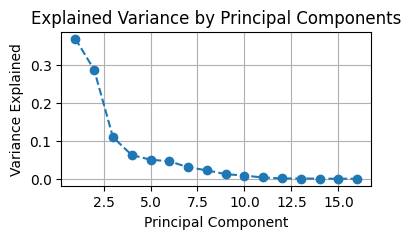

        PC1       PC2       PC3
0 -0.418037  0.336687 -0.295782
1  0.456881  1.821216  0.115663
2  0.493754  1.009214  0.729176
3  0.573310  1.463066  2.837887
4 -1.818987  0.690542 -0.536023
       Region  Spring_tavg  Spring_tmin  Spring_tmax  Spring_prcp  \
PC1  0.068488     0.392502     0.381259     0.384409    -0.198818   
PC2 -0.043593    -0.003269    -0.021658    -0.018367     0.006060   
PC3 -0.037034     0.137721     0.205694     0.049774     0.482577   

     Spring_tsun  Summer_tavg  Summer_tmin  Summer_tmax  Summer_prcp  \
PC1     0.048971    -0.024693    -0.016084    -0.012785    -0.094199   
PC2     0.253011     0.455611     0.442093     0.449428    -0.214312   
PC3    -0.425355     0.056089     0.132397    -0.018080     0.364418   

     Summer_tsun  Fall_tavg  Fall_tmin  Fall_tmax  Fall_prcp  Fall_tsun  
PC1    -0.146981   0.370969   0.315211   0.382563  -0.149228   0.262844  
PC2     0.407662   0.139684   0.201897   0.066170   0.117071  -0.194273  
PC3    -0.148505   0

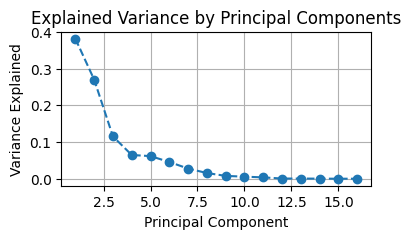

        PC1       PC2       PC3
0  1.151648  2.692835  0.380488
1 -0.242583  1.129814  1.143076
2 -1.549297 -0.073113  0.116170
3 -1.386446 -0.068321  0.266295
4 -0.879837  1.955100 -1.186601
       Region  Spring_tavg  Spring_tmin  Spring_tmax  Spring_prcp  \
PC1  0.039876     0.389876     0.380264     0.385516    -0.105445   
PC2  0.050098    -0.004074    -0.031137    -0.013201     0.067547   
PC3 -0.003219     0.078181     0.154355     0.000359     0.549839   

     Spring_tsun  Summer_tavg  Summer_tmin  Summer_tmax  Summer_prcp  \
PC1     0.079964    -0.029499    -0.035867     0.002475    -0.128806   
PC2     0.264635     0.469555     0.452184     0.468720    -0.178444   
PC3    -0.376023     0.039993     0.109286    -0.018277     0.391245   

     Summer_tsun  Fall_tavg  Fall_tmin  Fall_tmax  Fall_prcp  Fall_tsun  
PC1    -0.120391   0.379213   0.330036   0.385945  -0.097651   0.302005  
PC2     0.431439   0.101221   0.142696   0.053170   0.111403  -0.115142  
PC3    -0.086310   0

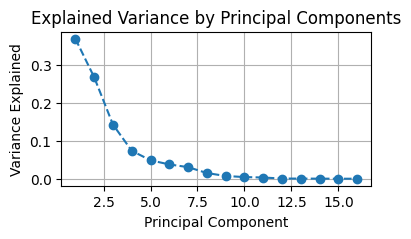

        PC1       PC2       PC3
0 -1.548111  0.735182 -3.615253
1  1.998542  0.532836 -0.173331
2 -1.429865  1.159388 -1.282617
3  0.050570 -0.050444 -0.247093
4 -8.976241  0.103159 -2.632087
       Region  Spring_tavg  Spring_tmin  Spring_tmax  Spring_prcp  \
PC1 -0.024485     0.366606     0.365017     0.331738    -0.049086   
PC2 -0.156254    -0.187322    -0.171743    -0.237578     0.203731   
PC3 -0.023490    -0.050980    -0.117691     0.021168    -0.462795   

     Spring_tsun  Summer_tavg  Summer_tmin  Summer_tmax  Summer_prcp  \
PC1     0.059148     0.221377     0.233272     0.208654    -0.127655   
PC2     0.125023     0.393466     0.377011     0.380224    -0.076213   
PC3     0.540367     0.024567    -0.028961     0.090009    -0.460632   

     Summer_tsun  Fall_tavg  Fall_tmin  Fall_tmax  Fall_prcp  Fall_tsun  
PC1     0.044897   0.395841   0.377745   0.370328   0.058896   0.102663  
PC2     0.440664  -0.044013   0.025149  -0.131601   0.213595  -0.300652  
PC3     0.187684  -0

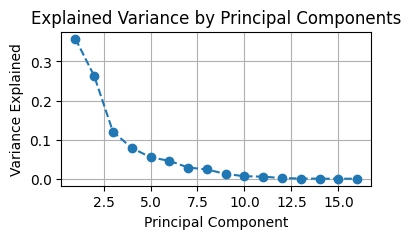

        PC1       PC2       PC3
0 -0.741497 -0.561731 -0.095417
1  2.192575 -8.412364  0.371600
2 -1.172973 -1.523747 -1.053502
3  1.264373  2.042767  0.122613
4 -0.456942  1.239883  1.965138
       Region  Spring_tavg  Spring_tmin  Spring_tmax  Spring_prcp  \
PC1  0.000090     0.386238     0.374445     0.378348    -0.155031   
PC2 -0.175889     0.008112    -0.010033    -0.011617    -0.052217   
PC3  0.336874     0.151729     0.150963     0.118961     0.514621   

     Spring_tsun  Summer_tavg  Summer_tmin  Summer_tmax  Summer_prcp  \
PC1     0.056861    -0.091233    -0.094178    -0.052199    -0.135994   
PC2     0.245812     0.460337     0.449986     0.455512    -0.167130   
PC3    -0.246900     0.110681     0.109951     0.108326     0.404739   

     Summer_tsun  Fall_tavg  Fall_tmin  Fall_tmax  Fall_prcp  Fall_tsun  
PC1    -0.169974   0.360232   0.303492   0.384307  -0.145879   0.286437  
PC2     0.406827   0.169391   0.204360   0.106340   0.074898  -0.053923  
PC3    -0.035613   0

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

for i, [name, df] in enumerate(file_names):
  print('★',name)

  features = ['Region',
      'Spring_tavg', 'Spring_tmin', 'Spring_tmax', 'Spring_prcp', 'Spring_tsun',
            'Summer_tavg', 'Summer_tmin', 'Summer_tmax', 'Summer_prcp', 'Summer_tsun',
            'Fall_tavg', 'Fall_tmin', 'Fall_tmax', 'Fall_prcp', 'Fall_tsun'
  ]

  # 提取特征数据
  X = df[features]

  # 标准化特征
  X_scaled = StandardScaler().fit_transform(X)

  # 创建 PCA 对象并拟合
  pca = PCA()
  X_pca = pca.fit_transform(X_scaled)

  # 查看各主成分的方差解释比率
  explained_variance = pca.explained_variance_ratio_
  print("Explained Variance Ratio:", explained_variance)

  # 画出主成分的方差解释比率
  plt.figure(figsize=(4, 2))
  plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
  plt.title('Explained Variance by Principal Components')
  plt.xlabel('Principal Component')
  plt.ylabel('Variance Explained')
  plt.grid()
  plt.show()

  # 选择主成分数
  n_components = 3  # 选择主成分的数量
  pca = PCA(n_components=n_components)
  X_pca_selected = pca.fit_transform(X_scaled)

  # 创建一个 DataFrame 包含选择的主成分
  principal_components_df = pd.DataFrame(data=X_pca_selected, columns=[f'PC{i+1}' for i in range(n_components)])

  # 显示结果
  print(principal_components_df.head())

  components = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

  print(components)
  print('-'*100,'\n')


## PCA Linear Regression & 5-fold cross-validation

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd

for i, [name, df] in enumerate(file_names):
  print('★',name)

  X = df.drop(columns=['Rating','Name'])
  y = df['Rating']

  # 步驟1：標準化
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # 步驟2：PCA
  pca = PCA(n_components=0.95)  # 保留95%的變異
  X_pca = pca.fit_transform(X_scaled)

  # 步驟3：分割數據
  X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

  # 步驟4：建模
  model = LinearRegression()
  model.fit(X_train, y_train)

  # 步驟5：預測
  y_pred = model.predict(X_test)

  # 評估模型性能
  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(y_test, y_pred)
  print("Mean Squared Error:", mse)

  print('\n5-fold cross-validation')
  # 步驟4：交叉驗證
  # 使用 5 折交叉驗證來計算平均的 MSE
  cv_scores = cross_val_score(model, X_pca, y, cv=5, scoring='neg_mean_squared_error')

  # 計算平均 MSE (neg_mean_squared_error 會返回負值，因此需要取負)
  mean_mse = -cv_scores.mean()

  print(f"Cross-validated Mean Squared Error: {mean_mse}")
  print('-'*100,'\n')

★ Red_Season.csv
Mean Squared Error: 0.06720685472741371

5-fold cross-validation
Cross-validated Mean Squared Error: 0.071743009058674
---------------------------------------------------------------------------------------------------- 

★ White_Season.csv
Mean Squared Error: 0.05148481188179222

5-fold cross-validation
Cross-validated Mean Squared Error: 0.05642534958393998
---------------------------------------------------------------------------------------------------- 

★ Rose_Season.csv
Mean Squared Error: 0.07152524700155584

5-fold cross-validation
Cross-validated Mean Squared Error: 0.07974608207494147
---------------------------------------------------------------------------------------------------- 

★ Sparkling_Season.csv
Mean Squared Error: 0.029915912369018322

5-fold cross-validation
Cross-validated Mean Squared Error: 0.05584568518494355
---------------------------------------------------------------------------------------------------- 



## Random Forest Regressor & 5-fold cross-validation

In [8]:
# 引入所需的套件
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

for i, [name, df] in enumerate(file_names):
  print('★',name)

  features = [
      'Spring_tavg', 'Spring_tmin', 'Spring_tmax', 'Spring_prcp', 'Spring_tsun',
      'Summer_tavg', 'Summer_tmin', 'Summer_tmax', 'Summer_prcp', 'Summer_tsun',
      'Fall_tavg', 'Fall_tmin', 'Fall_tmax', 'Fall_prcp', 'Fall_tsun'
  ]

  # 假設你的數據框是 df，其中 'Rating' 是目標變數，features 是特徵列表
  X = df[features]  # 特徵數據
  y = df['Rating']  # 目標變數

  # 將數據分為訓練集和測試集
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # 初始化隨機森林回歸模型
  rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

  # 訓練模型
  rf_regressor.fit(X_train, y_train)

  # 預測測試集
  y_pred = rf_regressor.predict(X_test)

  # 計算均方誤差（MSE）
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")

  print('\nFeature_Importance')
  # 如果你想查看特徵的重要性，可以這樣做
  feature_importances = rf_regressor.feature_importances_
  for feature, importance in zip(features, feature_importances):
      print(f"{feature}: {importance:.4f}")

  print('\n5-fold cross-validation')
  # 使用 5 折交叉驗證
  cv_scores = cross_val_score(rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

  # 計算交叉驗證的 MSE (neg_mean_squared_error 會返回負值，所以取相反值)
  cv_mse = -cv_scores.mean()

  print(f"Cross-validated MSE: {cv_mse}")
  print('-'*100,'\n')

★ Red_Season.csv
Mean Squared Error: 0.06822400662458687

Feature_Importance
Spring_tavg: 0.0505
Spring_tmin: 0.0570
Spring_tmax: 0.0656
Spring_prcp: 0.0698
Spring_tsun: 0.0763
Summer_tavg: 0.0493
Summer_tmin: 0.0547
Summer_tmax: 0.0498
Summer_prcp: 0.0795
Summer_tsun: 0.1063
Fall_tavg: 0.0615
Fall_tmin: 0.0601
Fall_tmax: 0.0529
Fall_prcp: 0.0783
Fall_tsun: 0.0885

5-fold cross-validation
Cross-validated MSE: 0.07229893891692471
---------------------------------------------------------------------------------------------------- 

★ White_Season.csv
Mean Squared Error: 0.05597418266179876

Feature_Importance
Spring_tavg: 0.0438
Spring_tmin: 0.0619
Spring_tmax: 0.0926
Spring_prcp: 0.0628
Spring_tsun: 0.0678
Summer_tavg: 0.0382
Summer_tmin: 0.0492
Summer_tmax: 0.0605
Summer_prcp: 0.0608
Summer_tsun: 0.1009
Fall_tavg: 0.0425
Fall_tmin: 0.0754
Fall_tmax: 0.0519
Fall_prcp: 0.0712
Fall_tsun: 0.1206

5-fold cross-validation
Cross-validated MSE: 0.06137927079453685
-----------------------------

## Deep Learning

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

for i, [name, df] in enumerate(file_names):
    print('★',name)

    X = df.drop(columns=['Rating', 'Name'])
    y = df['Rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Sequential()

    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}\n")


#model.save('wine_rating_model.h5')

★ Red_Season.csv


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 7.3315 - val_loss: 0.9609
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5622 - val_loss: 0.4847
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3311 - val_loss: 0.3347
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2238 - val_loss: 0.2701
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1676 - val_loss: 0.2247
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1328 - val_loss: 0.1761
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1085 - val_loss: 0.1390
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0968 - val_loss: 0.1184
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0850 - val_loss: 0.1157
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0761 - val_loss: 0.1000
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0660 - val_loss: 0.0975
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 13.8323 - val_loss: 3.9701
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3602 - val_loss: 1.0868
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8696 - val_loss: 0.6999
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6329 - val_loss: 0.5378
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4831 - val_loss: 0.4489
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4083 - val_loss: 0.3806
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3085 - val_loss: 0.3382
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2913 - val_loss: 0.2878
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2370 - val_loss: 0.2599
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2113 - val_loss: 0.2374
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1985 - val_loss: 0.2080
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1728 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - loss: 16.4342 - val_loss: 14.7058
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 14.4896 - val_loss: 12.8227
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.5684 - val_loss: 11.2699
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.1527 - val_loss: 9.7694
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.7115 - val_loss: 8.2896
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9631 - val_loss: 6.8607
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4607 - val_loss: 5.5392
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.4344 - val_loss: 4.4073
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9513 - val_loss: 3.5131
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9074 - val_loss: 2.8960
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3881 - val_loss: 2.5115
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2281 - val_loss: 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 602ms/step - loss: 13.4743 - val_loss: 11.1955
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.4565 - val_loss: 9.2671
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9111 - val_loss: 7.5138
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4192 - val_loss: 5.9789
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6880 - val_loss: 4.7030
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.5308 - val_loss: 3.6915
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1902 - val_loss: 2.9467
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1439 - val_loss: 2.4560
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5332 - val_loss: 2.1113
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1582 - val_loss: 1.9006
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9332 - val_loss: 1.7166
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7546 - val_loss: 1.52

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Mean Squared Error: 0.16211891176135163



# DATA VISUALIZATION
1. Sunshine Duration vs. Ratings
  - The sunshine duration in spring and summer shows that longer sunshine hours (over 30,000 seconds) are positively correlated with higher ratings (4.4 to 4.8).
  - In autumn, the impact of different sunshine durations on ratings appears relatively balanced, with no obvious trends, although red wine tends to have slightly higher ratings under longer sunshine.
2. Mean Temperature vs. Ratings
  - In spring and summer, the correlation between temperature and ratings is not easily discernible, with temperatures ranging from 5°C to 25°C.
  - The impact of autumn temperatures on the ratings of various wines seems more uniform, with most ratings concentrated between 4.2 and 4.6.
3. Precipitation vs. Ratings
  - During spring and summer, lower precipitation levels (about 0 to 5mm) result in slightly higher ratings for most types of wine (especially red wine), but once precipitation exceeds a certain amount (>5mm), the rating trend becomes flatter.
  - The changes in precipitation during autumn do not show significant impacts on ratings, but when precipitation is below 5mm, the overall ratings seem to be slightly higher, particularly affecting red wine.

# 資料可視化
1. 日照時間 (Sunshine Duration) vs. 評分
  - 春季和夏季的日照時間顯示出，較長的日照時間（超過30,000秒）與高評分（4.4至4.8）呈現正相關。
  - 在秋季，不同日照時間對評分的影響相對均衡，未見明顯的趨勢，儘管紅酒在較長的日照下評分略高。
2. 平均氣溫 (Mean Temperature) vs. 評分
  - 在春季和夏季，氣溫和評分的相關性較難發現明顯趨勢，氣溫範圍在5°C到25°C之間。
  - 秋季的氣溫對各類酒評分的影響似乎較均勻，且大多數評分集中在4.2至4.6之間。
3. 降水量 (Precipitation) vs. 評分
  - 春季和夏季降水量較低時（約0至5mm），大部分類型的葡萄酒（特別是紅酒）評分略高，但超過一定降水量（>5mm）後，評分趨勢變得較為平坦。
  - 秋季降水量的變化對評分的影響也並不明顯，但當降水量低於5mm時，整體評分似乎稍高，尤其對紅酒的影響更為明顯。

## Visualization － Sunshine vs High Wine Rating

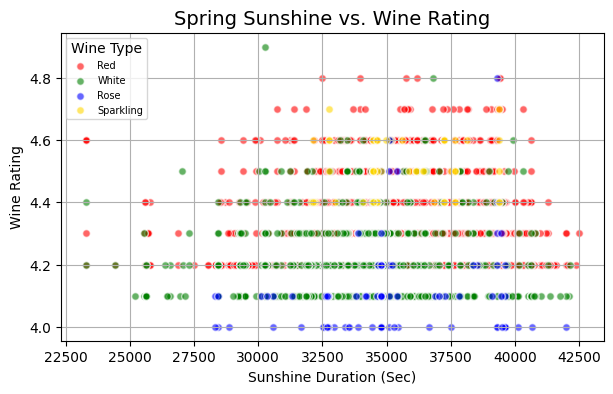

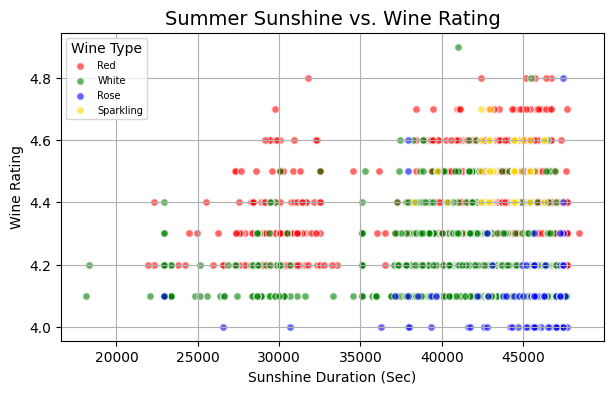

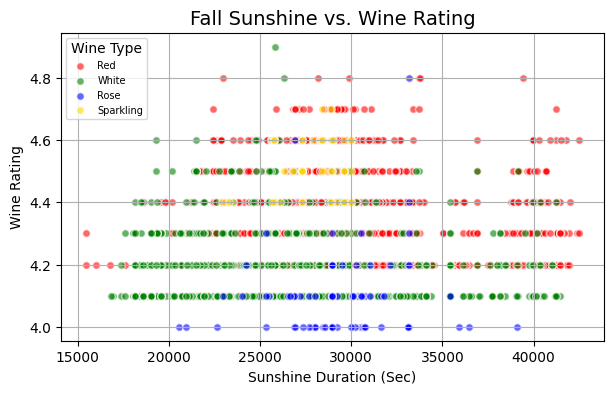

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

desired_order = ['Red_Season.csv', 'White_Season.csv', 'Rose_Season.csv', 'Sparkling_Season.csv']
file_names = sorted(file_names, key=lambda x: desired_order.index(x[0]))

colors = ['red', 'green', 'blue', 'gold']  # 每種酒類的顏色
seasons = ['Spring_tsun', 'Summer_tsun', 'Fall_tsun']  # 要比較的不同季節
titles = ['Spring Sunshine vs. Wine Rating', 'Summer Sunshine vs. Wine Rating', 'Fall Sunshine vs. Wine Rating']


# 將不同季節的數據分開繪製
for season, title in zip(seasons, titles):
    plt.figure(figsize=(7, 4))  # 設置圖形大小
    for i, (name, df) in enumerate(file_names):
        # 將評分按分位數分組，並篩選出高評分的葡萄酒數據
        df['Rating_bin'] = pd.qcut(df['Rating'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
        df_high_rating = df[df['Rating_bin'] == 'High']

        # 繪製不同酒類的散佈圖，使用不同顏色
        plt.scatter(df_high_rating[season], df_high_rating['Rating'], color=colors[i], alpha=0.6, edgecolors='w', s=30, label=name)

    # 添加標題和標籤
    plt.title(title, fontsize=14)
    plt.xlabel('Sunshine Duration (Sec)', fontsize=10)
    plt.ylabel('Wine Rating', fontsize=10)
    plt.grid(True)
    plt.legend(title="Wine Type", fontsize=7, labels=['Red', 'White', 'Rose', 'Sparkling'])  # 顯示圖例
    plt.show()

## Visualization - Temperature vs. Wine Rating

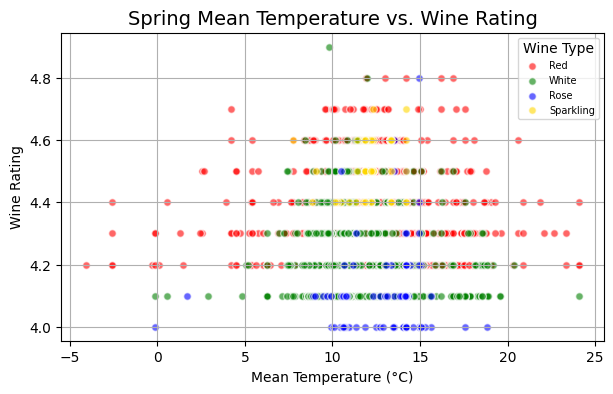

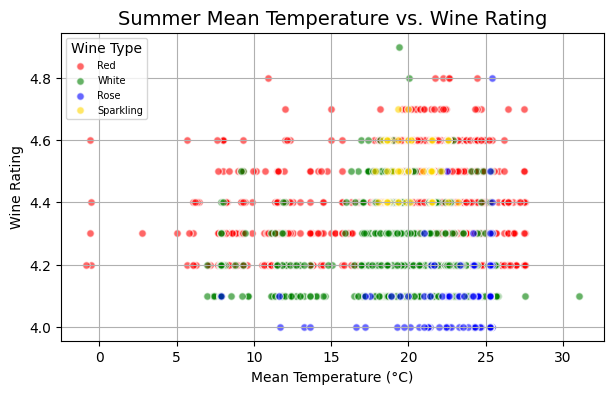

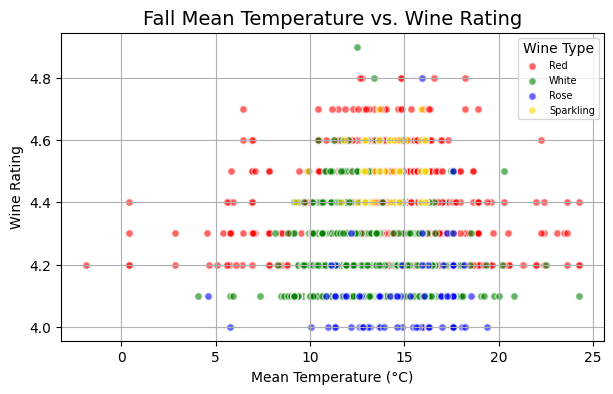

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

desired_order = ['Red_Season.csv', 'White_Season.csv', 'Rose_Season.csv', 'Sparkling_Season.csv']
file_names = sorted(file_names, key=lambda x: desired_order.index(x[0]))

colors = ['red', 'green', 'blue', 'gold']  # 每種酒類的顏色
temperature = ['Spring_tavg', 'Summer_tavg', 'Fall_tavg']  # 要比較的不同季節
titles = ['Spring Mean Temperature vs. Wine Rating', 'Summer Mean Temperature vs. Wine Rating', 'Fall Mean Temperature vs. Wine Rating']


# 將不同季節的數據分開繪製
for season, title in zip(temperature, titles):
    plt.figure(figsize=(7, 4))  # 設置圖形大小
    for i, (name, df) in enumerate(file_names):
        # 將評分按分位數分組，並篩選出高評分的葡萄酒數據
        df['Rating_bin'] = pd.qcut(df['Rating'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
        df_high_rating = df[df['Rating_bin'] == 'High']

        # 繪製不同酒類的散佈圖，使用不同顏色
        plt.scatter(df_high_rating[season], df_high_rating['Rating'], color=colors[i], alpha=0.6, edgecolors='w', s=30, label=name)

    # 添加標題和標籤
    plt.title(title, fontsize=14)
    plt.xlabel('Mean Temperature (°C)', fontsize=10)
    plt.ylabel('Wine Rating', fontsize=10)
    plt.grid(True)
    plt.legend(title="Wine Type", fontsize=7, labels=['Red', 'White', 'Rose', 'Sparkling'])  # 顯示圖例
    plt.show()

## Visualization - Precipitation vs. Wine Rating

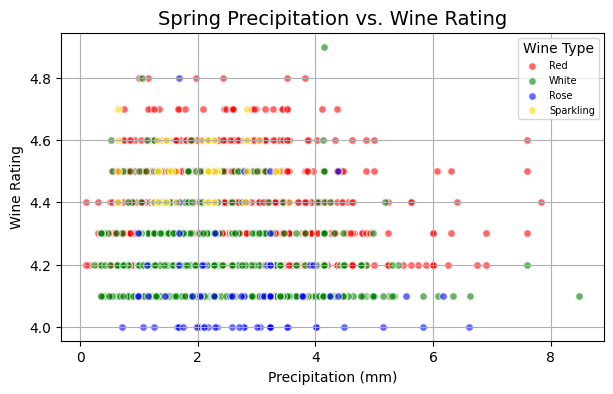

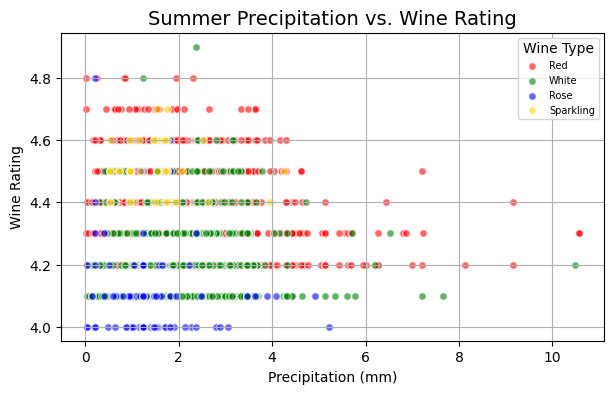

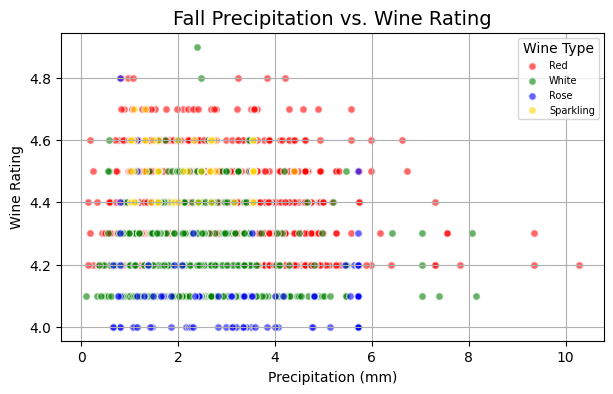

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

desired_order = ['Red_Season.csv', 'White_Season.csv', 'Rose_Season.csv', 'Sparkling_Season.csv']
file_names = sorted(file_names, key=lambda x: desired_order.index(x[0]))

colors = ['red', 'green', 'blue', 'gold']  # 每種酒類的顏色
prcp = ['Spring_prcp', 'Summer_prcp', 'Fall_prcp']  # 要比較的不同季節
titles = ['Spring Precipitation vs. Wine Rating', 'Summer Precipitation vs. Wine Rating', 'Fall Precipitation vs. Wine Rating']


# 將不同季節的數據分開繪製
for season, title in zip(prcp, titles):
    plt.figure(figsize=(7, 4))  # 設置圖形大小
    for i, (name, df) in enumerate(file_names):
        # 將評分按分位數分組，並篩選出高評分的葡萄酒數據
        df['Rating_bin'] = pd.qcut(df['Rating'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
        df_high_rating = df[df['Rating_bin'] == 'High']

        # 繪製不同酒類的散佈圖，使用不同顏色
        plt.scatter(df_high_rating[season], df_high_rating['Rating'], color=colors[i], alpha=0.6, edgecolors='w', s=30, label=name)

    # 添加標題和標籤
    plt.title(title, fontsize=14)
    plt.xlabel('Precipitation (mm)', fontsize=10)
    plt.ylabel('Wine Rating', fontsize=10)
    plt.grid(True)
    plt.legend(title="Wine Type", fontsize=7, labels=['Red', 'White', 'Rose', 'Sparkling'])  # 顯示圖例
    plt.show()

# CONCLUSION
This project successfully constructed several models to predict wine ratings through the analysis of weather data. After comparison, the Random Forest Regression and Principal Component Analysis (PCA) models achieved a good balance between performance and computational resources, showing lower Mean Squared Error (MSE) values.

In the correlation analysis, it was found that no single feature has a high correlation with the ratings; only the region of Sparkling Wine shows a higher correlation with ratings (0.42). Visual observation of the relationship between ratings and region reveals that the Champagne region's ratings are significantly higher than those of other regions, leading to a high correlation.

In the feature selection for weather characteristics, three regression analysis methods were compared comprehensively, with the following results:

- Lasso Regression
  - Sunshine duration (tsun) has a significant influence on wine ratings.

- Principal Component Analysis (PCA)
  - The temperatures (tavg/tmin/tmax) in spring and autumn have a high influence, explaining about 35% of the variance.
  - Summer temperatures (tavg/tmin/tmax) and sunshine duration (tsun) have the next highest influence, explaining about 26% of the variance.

- Random Forest Regression
  - Summer and autumn sunshine duration (tsun) significantly affects the ratings of red and white wines.
  - Spring sunshine duration (tsun) and autumn precipitation (prcp) have a larger impact on rosé wines.
  - Summer precipitation (prcp) has the greatest effect on sparkling wines, holding the highest weight.
  - Temperature (tavg/tmin/tmax) has a lesser influence on all types of wines compared to sunshine and precipitation.

Summary
  - Sunshine duration has a consistent and significant influence on the ratings of all types of wines. Moderate sunshine (8-11 hours) is needed in spring, high sunshine (10-13 hours) in summer, and low sunshine (6-9 hours) in autumn.
  - The impact of temperature on different wine types is not obvious, but temperatures in spring and autumn (5-20°C) significantly influence wine quality, while summer temperatures also have some effect on ratings.
  - Precipitation shows a strong correlation with specific types of wine ratings, with sparkling wines and rosé wines requiring low precipitation (0-2mm) in summer and moderate precipitation (0.5-4mm) in autumn.

# 結論

本專案通過對天氣數據進行分析，成功地構建了幾個模型來預測葡萄酒的評分。經過比較，隨機森林回歸和主成分分析 (PCA) 模型在效能與計算資源之間取得了良好平衡，顯示出較低的 MSE 值。

在相關性分析中，可發現沒有單一特徵對Rating有高度相關性，只有Sparkling Wine的Region與Rating的相關性較高(0.42)，進行可視化觀察Rating與Region的關係，可發現香檳區的Rating明顯高於其他Region，因此導致高相關性

在天氣的特徵篩選中，綜合比較了三種回歸分析方法，結果如下：
- Lasso 回歸：
  - 日照時間 (tsun) 對葡萄酒評分具有較高的影響力。
- 主成分分析 (PCA)：
  - 春秋兩季的氣溫 (tavg/tmin/tmax) 具有較高的影響力，解釋了約 35% 的變異率。
  - 夏季的氣溫 (tavg/tmin/tmax) 與 日照時間 (tsun) 影響力次高，解釋了約 26% 的變異率。
- 隨機森林回歸：
  - 夏季和秋季的日照時間 (tsun) 對紅白葡萄酒評分影響顯著。
  - 春季日照時間 (tsun) 和 秋季降水 (prcp) 對玫瑰酒的影響較大。
  - 夏季降水 (prcp) 對氣泡酒的影響最大，佔據了最高權重。
  - 氣溫 (tavg/tmin/tmax) 對所有類型葡萄酒的影響次於日照和降水。

總結：
- 日照時間 對所有類型的葡萄酒評分具有一致且重要的影響力，春季需要中等日照量(8～11小時)，夏季需要高等日照量(10～13小時)，秋季需要低等日照量(6～9小時)。
- 氣溫 對於不同酒類的影響不明顯，但春秋兩季的氣溫對葡萄酒品質影響較明顯(5～20°C)，夏季氣溫對評分也有一定影響。
- 降水量 對特定類型葡萄酒的評分有較強的關聯性，可以發現氣泡酒與玫瑰酒在夏季需要低等降水量(0～2mm)，秋季需要中等降水量(0.5～4mm)。